# Neural Machine Translation with Attention

Advanced Learning Fall 2024.   
Last updated: 2025-01-12


For SUBMISSION:   

Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 208088815
~~~

~~~
STUDENT GIT LINK: MISSING
~~~
In Addition, don't forget to add your ID to the files, and upload to moodle the html version:    
  
`PS3_Attention_2024_ID_[000000000].html`   




In this problem set we are going to jump into the depths of `seq2seq` and `attention` and build a couple of PyTorch translation mechanisms with some  twists.     


*   Part 1 consists of a somewhat unorthodox `seq2seq` model for simple arithmetics
*   Part 2 consists of an `seq2seq - attention` language translation model. We will use it for Hebrew and English.  


---

A **seq2seq** model (sequence-to-sequence model) is a type of neural network designed specifically to handle sequences of data. The model converts input sequences into other sequences of data. This makes them particularly useful for tasks involving language, where the input and output are naturally sequences of words.

Here's a breakdown of how `seq2seq` models work:

* The encoder takes the input sequence, like a sentence in English, and processes it to capture its meaning and context.

* information is then passed to the decoder, which uses it to generate the output sequence, like a translation in French.

* Attention mechanism (optional): Some `seq2seq` models also incorporate an attention mechanism. This allows the decoder to focus on specific parts of the input sequence that are most relevant to generating the next element in the output sequence.

`seq2seq` models are used in many natural language processing (NLP) tasks.



imports: (feel free to add)

In [1]:
# from __future__ import unicode_literals, print_function, division
# from io import open
# import unicodedata
import re
import random
import unicodedata

import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

import os
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import zipfile

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

import time
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Part 2: A language translation model with attention

In this part of the problem set we are going to implement a translation with a Sequence to Sequence Network and Attention model.

0) Please go over the NLP From Scratch: Translation with a Sequence to Sequence Network and Attention [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). This attention model is very similar to what was learned in class (Luong), but a bit different. What are the main differences between  Badahnau and Luong attention mechanisms?    



0) The main differences between Bahdanau (Additive) and Luong (Multiplicative) attention mechanisms are:

1. Alignment Score Calculation:

Bahdanau Attention: Uses a feed-forward neural network with a non-linear transformation to compute attention scores. This involves learned weights, making it more flexible but computationally expensive.
Luong Attention: Uses a dot product between the decoder hidden state and encoder hidden states, making it computationally efficient.

2. Computation Complexity:

Bahdanau Attention: More computationally expensive due to the additional feed-forward network.
Luong Attention: More efficient since the dot product is a simpler operation.

3. When Attention is Applied:

Bahdanau Attention: Applies attention before generating the next decoder hidden state.
Luong Attention: Applies attention after computing the decoder hidden state.

4. Length of sequence:

Bahdanau best when dealing with long, complex sequences that require flexible alignment.
Luong best when working with shorter or well-aligned sequences for efficiency.

1.a) Using `!wget`, `!unzip` , download and extract the [hebrew-english](https://www.manythings.org/anki/) sentence pairs text file to the Colab `content/`  folder (or local folder if not using Colab).
1.b) The `heb.txt` must be parsed and cleaned (see tutorial for requirements or change the code as you see fit).   


In [2]:
# Define dataset URL (replace with the actual link if different)
dataset_url = "https://www.manythings.org/anki/heb-eng.zip"

# Download the dataset
!wget -O hebrew-english.zip {dataset_url}

# Create a folder if it doesn't exist
os.makedirs("content", exist_ok=True)

# Extract the zip file into content/ folder
!unzip -o hebrew-english.zip -d content/

--2025-02-06 17:46:03--  https://www.manythings.org/anki/heb-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4466359 (4.3M) [application/zip]
Saving to: ‘hebrew-english.zip’

hebrew-english.zip  100%[===================>]   4.26M  2.73MB/s    in 1.6s    

2025-02-06 17:46:05 (2.73 MB/s) - ‘hebrew-english.zip’ saved [4466359/4466359]

Archive:  hebrew-english.zip
  inflating: content/_about.txt      
  inflating: content/heb.txt         


In [3]:
# Check the current working directory
print("Current working directory:", os.getcwd())

# List the files and folders in the current directory
os.listdir()

with zipfile.ZipFile("hebrew-english.zip", 'r') as zip_ref:
    zip_ref.extractall("content/")

# List the files and folders in the current directory
print(os.listdir('content'))


Current working directory: /content
['_about.txt', 'heb.txt']


In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Convert Unicode to plain ASCII (for English only)
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Normalize English text: lowercase, trim, remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z\u0590-\u05FF!?]+", r" ", s)
    return s.strip()

# Read the Hebrew-English dataset
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the Hebrew-English dataset
    lines = open('content/heb.txt', encoding='utf-8').read().strip().split('\n')

    # Split into pairs, but discard the attribution (everything after the second tab)
    pairs = [[s.strip().split('\t')[0], s.strip().split('\t')[1]] for s in lines if len(s.split('\t')) >= 2]

    # Normalize the sentences
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs if needed
    if reverse:
      pairs = [list(reversed(p)) for p in pairs]
      input_lang = Lang(lang2)
      output_lang = Lang(lang1)
    else:
      input_lang = Lang(lang1)
      output_lang = Lang(lang2)

    pairs = [pair[1:] for pair in pairs]
    return input_lang, output_lang, pairs

MAX_LENGTH = 10

def filterPair(p):
    if 'cc by france attribution tatoeba org' in p[0] or 'cc by france attribution tatoeba org' in p[1]:
        return False
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

# Hebrew → English
input_lang, output_lang, pairs = prepareData('eng', 'heb', True)

# Print a random example
print(random.choice(pairs))

Reading lines...
Read 128133 sentence pairs
Trimmed to 113428 sentence pairs
Counting words...
Counted words:
heb 34801
eng 12303
['תפתח בבקשה את הבקבוק', 'please open the bottle']


2.a) Use the tutorial example to build  and train a Hebrew to English translation model with attention (using the parameters in the code cell below). Apply the same `eng_prefixes` filter to limit the train/test data.   
2.b) Evaluate your trained model randomly on 20 sentences.  
2.c) Show the attention plot for 5 random sentences.  


In [5]:
# use the following parameters:
MAX_LENGTH = 10
hidden_size = 128
epochs = 50

SOLUTION:

In [6]:
### MISSING
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'heb', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

def evaluateRandomly(encoder, decoder, n=20):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [7]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, n_epochs=epochs, print_every=5, plot_every=5)

Reading lines...
Read 128133 sentence pairs
Trimmed to 113428 sentence pairs
Counting words...
Counted words:
heb 34801
eng 12303
7m 8s (- 64m 15s) (5 10%) 1.6375
14m 8s (- 56m 34s) (10 20%) 0.8796
21m 7s (- 49m 18s) (15 30%) 0.6390
28m 7s (- 42m 11s) (20 40%) 0.5124
35m 8s (- 35m 8s) (25 50%) 0.4340
42m 10s (- 28m 6s) (30 60%) 0.3794
49m 10s (- 21m 4s) (35 70%) 0.3394
56m 11s (- 14m 2s) (40 80%) 0.3090
63m 11s (- 7m 1s) (45 90%) 0.2845
70m 13s (- 0m 0s) (50 100%) 0.2659


In [9]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> תום קרא ביסודיות את החוזה
= tom carefully read over the contract
< tom read carefully at the contract <EOS>

> בוא ניגש לעניין
= let s cut to the chase
< let s settle on the point with him <EOS>

> כך זה בדיוק קרה לפני שלוש שנים
= that s exactly how it happened three years ago
< it just happened so long than three years ago <EOS>

> נסענו לגיפו
= we went to gifu
< it was going to how we deal to see <EOS>

> אני מאוד אוהב כלבים
= i love dogs
< i like dogs too much of dogs <EOS>

> אני מרגיש כמו איזה אדם אחר
= i feel like another person
< i feel like another person <EOS>

> טום אינו יודע מה מעיק על מרי
= tom doesn t know what s bothering mary
< tom knows what s bothering mary <EOS>

> חם מדי בפנים
= it s too hot inside
< it s too hot till six o clock is <EOS>

> לא עשיתי שום דבר במשך החופשה
= i did nothing during the holidays
< i did nothing during the holidays <EOS>

> את צריכה לשים לב יותר לאיות ולפיסוק
= you must be more careful about spelling and punctuation
< you must be more care

In [20]:
%matplotlib inline

def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    input_tokens = input_sentence.split(' ') + ['<EOS>']
    output_tokens = output_words

    ax.set_xticks(range(len(input_tokens)))
    ax.set_xticklabels(input_tokens[::-1], rotation=90, ha='right')

    ax.set_yticks(range(len(output_tokens)))
    ax.set_yticklabels(output_tokens, ha='right', va='center')

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

> השלג משקף את האור העל סגולי
= snow reflects ultraviolet light
input = השלג משקף את האור העל סגולי
output = snow reflects ultraviolet light <EOS>


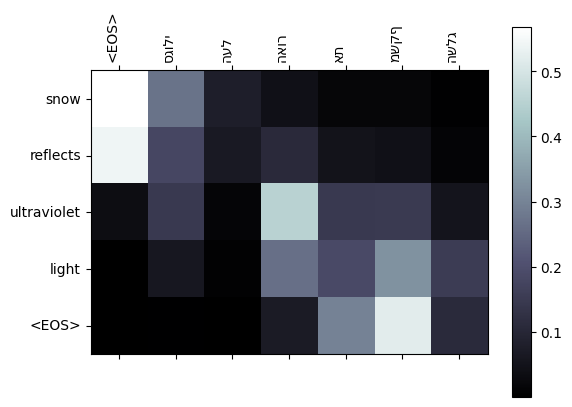

> זה פועל
= this works
input = זה פועל
output = this works works <EOS>


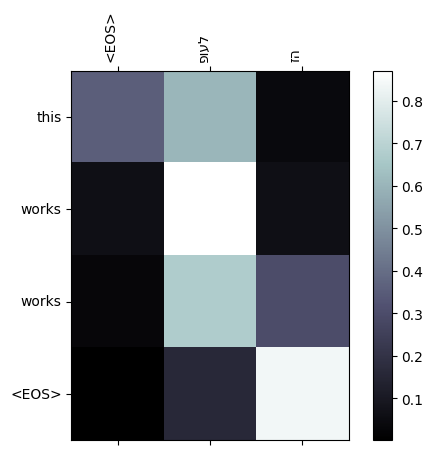

> הם חברים קרובים מאוד
= they re very close friends
input = הם חברים קרובים מאוד
output = they re very close friends <EOS>


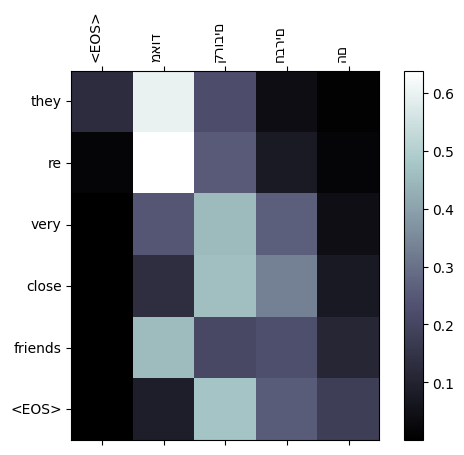

> המתן עד שאספור עד עשר
= wait till i count to ten
input = המתן עד שאספור עד עשר
output = wait till i lie to ten <EOS>


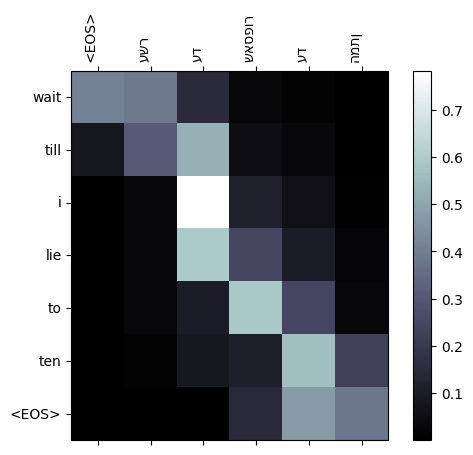

> הוא נושא מישרה בכירה בשלטון
= he holds a senior position in the government
input = הוא נושא מישרה בכירה בשלטון
output = he holds a position of high holds any old of


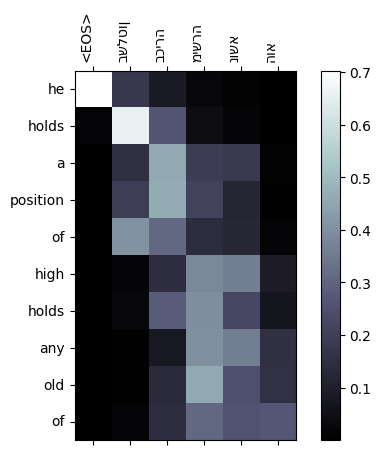

In [21]:
num_pairs = 5
for _ in range(num_pairs):
    pair = random.choice(pairs)
    print('>', pair[0])
    print('=', pair[1])

    evaluateAndShowAttention(pair[0])

3) Do you think this model performs well? Why or why not? What are its limitations/disadvantages? What would you do to improve it?  


The model demonstrates some positive learning trends, such as a steady decrease in loss, which indicates that it is improving its performance as training progresses. This is a good sign that the model is learning from the data over time. However, when looking at the translations it generates, there are noticeable issues. While some translations are accurate, many others are awkward or completely incorrect.

Limitations of the Model:
One of the primary limitations of this model is the lack of a bidirectional encoder. The current implementation uses a single-directional GRU, which processes sequences from left to right. While this works well in many cases, it might struggle to capture dependencies between words that are far apart in the sentence.

The attention mechanism used in the model is based on the Bahdanau attention mechanism. While this is a strong starting point, it may not fully leverage the dynamic nature of attention, especially in complex sentence structures or when dealing with long-range dependencies. This could be further improved by incorporating more sophisticated attention mechanisms, such as Luong attention or self-attention, which have shown better performance in certain tasks.

Regularization is another area where the model could be improved. While dropout is applied to the encoder embedding, the decoder and attention mechanisms lack regularization techniques.

Suggested Improvements:
To address the limitations mentioned, the model can be improved in several ways. First, replacing the single-directional GRU encoder with a bidirectional GRU would allow the model to capture dependencies from both the left and right contexts. This change would enhance the model’s ability to understand sentence structure and meaning, especially in languages with flexible word order.

To enhance the attention mechanism, experimenting with more advanced attention techniques, such as Luong Attention or the Transformer’s self-attention mechanism, could provide better performance. These mechanisms are designed to handle long-range dependencies more effectively and could improve the quality of the translations, especially in complex sentence structures.

Additionally, incorporating regularization techniques in the decoder and attention mechanisms would help prevent overfitting. Applying dropout or weight decay would improve the model’s ability to generalize, leading to better performance on unseen data.

4) Using any neural network architecture of your liking, build  a model with the aim to beat the model in 2.a. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

The answer to 4 is in another workbook.